In [1]:
import os
from omegaconf import OmegaConf
import hydra
import torch
os.environ['HYDRA_FULL_ERROR'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
import sys
sys.path.append('..')
import diffusion
from diffusers.utils import load_image
from torchvision.transforms.functional import to_tensor

cfg = OmegaConf.load('../configs/model/rf_dit_unclip.yaml')
model = hydra.utils.instantiate(cfg)
model = model.cuda()

model

[2024-11-06 15:17:22,890] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH


/export/home/ra63ral/miniconda3/envs/pytorch2.4/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.5
 [WARNING]  using untested triton version (3.0.0+dedb7bdf33), only 1.0.0 is known to be compatible


/export/scratch/ra63ral/miniconda3/envs/pytorch2.4/lib/python3.11/site-packages/deepspeed/runtime/zero/linear.py:47: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @autocast_custom_fwd
/export/scratch/ra63ral/miniconda3/envs/pytorch2.4/lib/python3.11/site-packages/deepspeed/runtime/zero/linear.py:66: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @autocast_custom_bwd
/export/scratch/ra63ral/miniconda3/envs/pytorch2.4/lib/python3.11/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutp

UnclipLatentRF2d(
  (unet): Transformer(
    (mid_level): Level(
      (0-27): 28 x TransformerLayer(
        (self_attn): CondAttentionBlock(
          d_head=72,
          (norm): AdaRMSNorm(
            eps=1e-06,
            (linear): Linear(in_features=1024, out_features=1152, bias=False)
          )
          (qkv_proj): Linear(in_features=1152, out_features=3456, bias=False)
          (pos_emb): AxialRoPE2D(dim=36, n_heads=16)
          (dropout): Dropout(p=0.0, inplace=False)
          (out_proj): Linear(in_features=1152, out_features=1152, bias=False)
        )
        (ff): FeedForwardBlock(
          (norm): AdaRMSNorm(
            eps=1e-06,
            (linear): Linear(in_features=1024, out_features=1152, bias=False)
          )
          (up_proj): LinearSwiGLU(in_features=1152, out_features=3456, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
          (down_proj): Linear(in_features=3456, out_features=1152, bias=False)
        )
      )
    )
    (mid_me

In [ ]:
ckpt_pth = '/export/home/ra49veb/dev/min-diffusion/diffusion/unclip.pt'
model.load_state_dict({ k: v for k, v in torch.load(ckpt_pth, map_location='cuda').items() if not 'ae' in k }, strict=False)
model.eval()

/tmp/ipykernel_2251300/474102111.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict({ k: v for k, v in torch.load(ckpt_pth, map_location='cuda').items

UnclipLatentRF2d(
  (unet): Transformer(
    (mid_level): Level(
      (0-27): 28 x TransformerLayer(
        (self_attn): CondAttentionBlock(
          d_head=72,
          (norm): AdaRMSNorm(
            eps=1e-06,
            (linear): Linear(in_features=1024, out_features=1152, bias=False)
          )
          (qkv_proj): Linear(in_features=1152, out_features=3456, bias=False)
          (pos_emb): AxialRoPE2D(dim=36, n_heads=16)
          (dropout): Dropout(p=0.0, inplace=False)
          (out_proj): Linear(in_features=1152, out_features=1152, bias=False)
        )
        (ff): FeedForwardBlock(
          (norm): AdaRMSNorm(
            eps=1e-06,
            (linear): Linear(in_features=1024, out_features=1152, bias=False)
          )
          (up_proj): LinearSwiGLU(in_features=1152, out_features=3456, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
          (down_proj): Linear(in_features=3456, out_features=1152, bias=False)
        )
      )
    )
    (mid_me

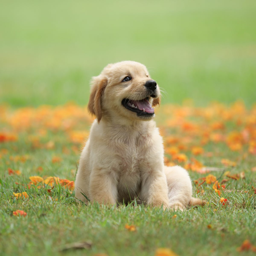

In [3]:
bs = 8
z = torch.randn(8, 4, 32, 32).cuda()
img = load_image('https://hips.hearstapps.com/hmg-prod/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=0.752xw:1.00xh;0.175xw,0&resize=1200:*')
img = img.resize((256, 256))
img_cond = to_tensor(img).unsqueeze(0).expand(bs, -1, -1, -1).cuda() * 2 -1
img

In [4]:
model.cfg_scale = 5

with torch.no_grad():
    res = model.sample(z=z, c_img=img_cond)

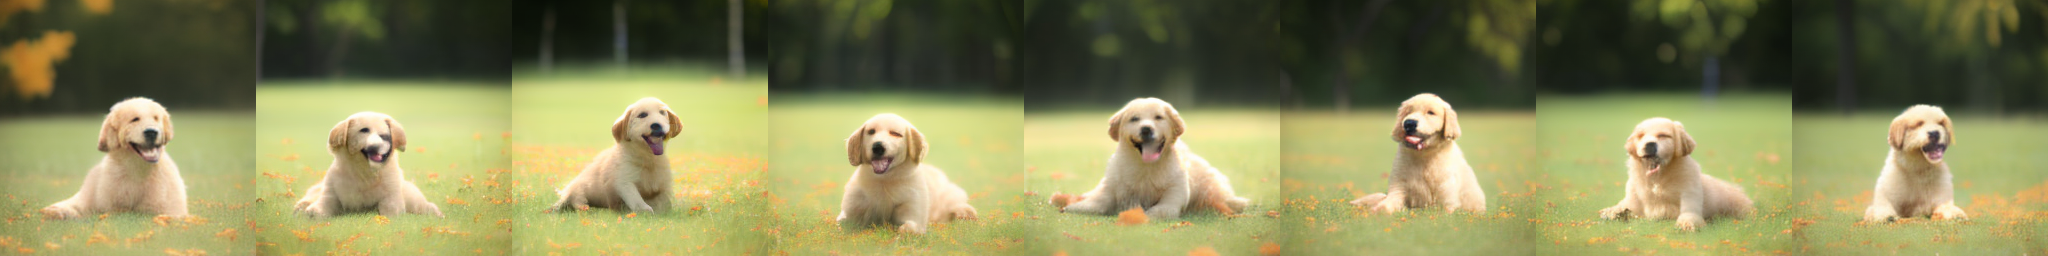

In [5]:
from torchvision.transforms.functional import to_pil_image
img = res.clip(-1, 1).float().cpu() * 0.5 + 0.5
from einops import rearrange
img = rearrange(img, 'b c h w -> c h (b w)')
to_pil_image(img)